In [1]:
import numpy as np
import pandas as pd
from math import exp, sqrt

from scipy.stats import norm
from scipy.integrate import quad

import matplotlib.pylab as plt
import seaborn as sns

from scipy.interpolate import CubicSpline

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style("dark")

# Importing and Cleaning the data required for the questions

In [3]:
df_comb = pd.read_csv('df_comb.csv', index_col=0)
df_comb = df_comb.rename(columns={'Tenor (year)':'Tenor', 'OIS Discount Factor':'OIS_DF', 'Forward LIBOR':'Forward_LIBOR', 'LIBOR Discount Factor':'LIBOR_DF'})

In [4]:
# Extracting the forward swap rates calculated in Qn 1
swap_rates = pd.read_csv('df_ForwardSwap.csv', index_col=0)
swap_rates = pd.DataFrame(data=swap_rates['Swap_Rate'].values.reshape(3,5), index=['1Y', '5Y', '10Y'], columns=['1Y', '2Y', '3Y', '5Y', '10Y'])

In [5]:
# Extracting the SABR Parameters from Part II
alpha_df = pd.read_csv('SABR_Alpha.csv', index_col=0)
alpha_df = alpha_df.drop(alpha_df.index[[0,1]])
alpha_df = pd.DataFrame(data=alpha_df.values.reshape(3,5), index=['1Y', '5Y', '10Y'], columns=['1Y', '2Y', '3Y', '5Y', '10Y'])

nu_df = pd.read_csv('SABR_Nu.csv', index_col=0)
nu_df = nu_df.drop(nu_df.index[[0,1]])
nu_df = pd.DataFrame(data=nu_df.values.reshape(3,5), index=['1Y', '5Y', '10Y'], columns=['1Y', '2Y', '3Y', '5Y', '10Y'])

rho_df = pd.read_csv('SABR_Rho.csv', index_col=0)
rho_df = rho_df.drop(rho_df.index[[0,1]])
rho_df = pd.DataFrame(data=rho_df.values.reshape(3,5), index=['1Y', '5Y', '10Y'], columns=['1Y', '2Y', '3Y', '5Y', '10Y'])

In [6]:
df_comb

,Tenor,LIBOR_DF,IRS Rate,OIS Rate,OIS_DF,OIS Overnight Rate,Forward_LIBOR
0,0.5,0.987654,0.0250,0.00250,0.997506,0.004994,0.025000
1,1.0,0.972579,0.0280,0.00300,0.997009,0.000997,0.031001
2,1.5,0.957406,NaN,NaN,0.995270,NaN,0.031695
3,2.0,0.942234,0.0300,0.00325,0.993531,0.003495,0.032205
4,2.5,0.926412,NaN,NaN,0.991773,NaN,0.034157
5,3.0,0.910590,0.0315,0.00335,0.990015,0.003545,0.034751
6,3.5,0.894868,NaN,NaN,0.988066,NaN,0.035138
7,4.0,0.879146,0.0325,0.00350,0.986117,0.003946,0.035766
8,4.5,0.864177,NaN,NaN,0.984150,NaN,0.034644
9,5.0,0.849208,0.0330,0.00360,0.982184,0.003996,0.035255


# Defining the necessary functions required for the questions

In [7]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

In [8]:
def Black76Lognormal(F, K, T, r, sigma, opt):
    d1 = (np.log(F/K)+(sigma*sigma/2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    if opt == 'Call':
        return F*exp(-r*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)
    elif opt == 'Put':
        return K*exp(-r*T)*norm.cdf(-d2) - F*exp(-r*T)*norm.cdf(-d1)

For static replication of any constant maturity swap (CMS) payoff $g(F)$, we use the following formula:

  \begin{equation*}
    \begin{split}
      V_0 &= D(0,T) g(F) + h'(F)[V^{pay}(F)-V^{rec}(F)] \\
      &\;\;\;\;\;\;\;\;\;\;+ \int_0^F h''(K) V^{rec}(K) dK +
      \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}

where

  \begin{equation*}
    \begin{split}
      h(K) &= \frac{g(K)}{\mbox{IRR}(K)} \\
      h'(K) &= \frac{\mbox{IRR}(K)g'(K) - g(K)\mbox{IRR}'(K)}{\mbox{IRR}(K)^2} \\
      h''(K) &= \frac{\mbox{IRR}(K)g''(K)-\mbox{IRR}''(K)g(K) -2\cdot\mbox{IRR}'(K)g'(K)}{\mbox{IRR}(K)^2} \\
      &\;\;\;\;\;\;\;\;\;\;+
      \frac{2\cdot\mbox{IRR}'(K)^2g(K)}{\mbox{IRR}(K)^3}.
    \end{split}
  \end{equation*}

For CMS rate payoff, the payoff function can be defined simply as $g(F)=F$, and the static replication formula simplifies into:

  \begin{equation*}
    \begin{split}
      D(0,T) F + \int_0^F h''(K) V^{rec}(K) dK + \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}

We can implement this in Python. First we define the IRR functions.

Let $m$ denote the payment frequenc ($m=2$ for semi-annual payment frequency), and let $N$ denote the tenor of the swap (number of years), the partial derivatives on the IRR function $\mbox{IRR}(S)$ given by:
\begin{equation*}
\begin{split}
\mbox{IRR}(K)&=\sum_{i=1}^{N\times m}\frac{1}{(1+\frac{K}{m})^i}=\frac{1}{K}\left[1-\frac{1}{\left(1+\frac{K}{m}\right)^{N\times m}}\right]\\
\mbox{IRR}'(K)&=-\frac{1}{K}\mbox{IRR}(K)
+\frac{1}{m\times K}\frac{N\times m}{\left(1+\frac{K}{m}\right)^{N\times m+1}} \\
\mbox{IRR}''(K)&=-\frac{2}{K}\mbox{IRR}'(K)
-\frac{1}{m^2\times K}\frac{N\times m\cdot (N\times m+1)}{\left(1+\frac{K}{m}\right)^{N\times m+2}} \\
\end{split}
\end{equation*}

These results will need to be generalised to handle the case for $m=2$ to be consistent with the semi-annual payment frequency swap market data provided.


In [9]:
def IRR_0(K, m, N):
    # implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    return value

def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/K*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/K*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative

For CMS rate payment, since $g(F)=F$, we have the derivatives:

\begin{equation*}
\begin{split}
g(K) &= K \\
g'(K) &= 1 \\
g''(K) &= 0
\end{split}
\end{equation*}

In [10]:
def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0

The function $h(K) = g(K)/IRR(K)$ now simplies into:

  \begin{equation*}
    \begin{split}
      h(K) &= \frac{g(K)}{\mbox{IRR}(K)} \\
      h'(K) &= \frac{\mbox{IRR}(K)g'(K) - g(K)\mbox{IRR}'(K)}{\mbox{IRR}(K)^2} \\
      h''(K) &= \frac{\mbox{IRR}(K)g''(K)-\mbox{IRR}''(K)g(K) -2\cdot\mbox{IRR}'(K)g'(K)}{\mbox{IRR}(K)^2} \\
      &\;\;\;\;\;\;\;\;\;\;+
      \frac{2\cdot\mbox{IRR}'(K)^2g(K)}{\mbox{IRR}(K)^3}.
    \end{split}
  \end{equation*}


In [11]:
def h_0(K, m, N):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, N)
    return value

def h_1(K, m, N):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, N)*g_1(K) - g_0(K)*IRR_1(K, m, N)) / IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, m, N):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = ((IRR_0(K, m, N)*g_2(K) - IRR_2(K, m, N)*g_0(K) - 2.0*IRR_1(K, m, N)*g_1(K))/IRR_0(K, m, N)**2
                        + 2.0*IRR_1(K, m, N)**2*g_0(K)/IRR_0(K, m, N)**3)
    return secondDerivative

In [12]:
def Forward_LIBOR(D_0 ,D_1, delta):
    forward_LIBOR = (1/delta)*((D_0 - D_1) / D_1 )
    return forward_LIBOR

def LIBOR_Discount_Factor(T):
    x = list(df_comb['Tenor'])
    y = list(df_comb['LIBOR_DF'])
    return np.interp(T, x, y)

def OIS_Discount_Factor(T):
    x = list(df_comb['Tenor'])
    y = list(df_comb['OIS_DF'])
    return np.interp(T, x, y)

In [13]:
def Forward_Swap_Rate(expiry, tenor, delta):
    month = int(tenor/delta)#number of payment after during tenor period
    float_leg, fixed_leg = 0, 0 #initialize fix and floating leg

    for i in range(1,month+1):
        loc = expiry + i*delta
        # float leg = OIS discount factor x forward LIBOR x delta
        float_leg += OIS_Discount_Factor(loc)*Forward_LIBOR(LIBOR_Discount_Factor(loc-delta), LIBOR_Discount_Factor(loc),delta)

    for i in range(1,month+1):
        # Fixed leg = Sum of OIS discount factor from Expiry to Tenor end
        fixed_leg += OIS_Discount_Factor(expiry + i*delta)

    return float_leg/fixed_leg

In [14]:
def Integrand(F, K, T, r, sigma, tenor, delta, opt):
    irr = IRR_0(K, 1/delta, tenor)
    H_2 = h_2(K, 1/delta, tenor)
    return H_2*irr*Black76Lognormal(F, K, T, r, sigma, opt)

In [15]:
def param_interpolation(expiry, tenor, data):
    splined_from_expiry = []
    for i in [1,2,3,5,10]:
        result = CubicSpline([1, 5, 10], data[str(i)+'Y'], bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
        splined_from_expiry.append(result)

    extract = []
    for i in range(5):
        extract.append(splined_from_expiry[i](expiry))

    result = CubicSpline([1,2,3,5,10], extract, bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
    return float(result(tenor))

In [16]:
def cms(expiry, tenor, delta):
    f       = Forward_Swap_Rate(expiry, tenor, delta)
    alpha   = param_interpolation(expiry,tenor,alpha_df)
    rho     = param_interpolation(expiry,tenor,rho_df)
    nu      = param_interpolation(expiry,tenor,nu_df)
    v_rec     = quad(lambda x:Integrand(f,x,expiry,0,
                                        SABR(f,x,expiry,alpha,0.9,rho,nu),
                                        tenor, delta, 'Put'), 0, f)[0]
    v_pay     = quad(lambda x:Integrand(f,x,expiry,0,
                                        SABR(f,x,expiry,alpha,0.9,rho,nu),
                                        tenor, delta, 'Call'), f, 0.1)[0]
    return f + v_rec + v_pay

In [17]:
def cms_pv(tenor, cms_period, delta):
    n = int(cms_period/delta)
    pv = 0
    for i in range(1,n+1):
        loc = i*delta
        pv += OIS_Discount_Factor(loc)*delta*cms(loc,tenor,delta)
    return pv

In [18]:
def decompose_lists(input_, output_):
    if type(input_) is list:
        for subitem in input_:
            decompose_lists(subitem, output_)
    else:
        output_.append(input_)

# Interpolation of SABR Parameters

## 10Y

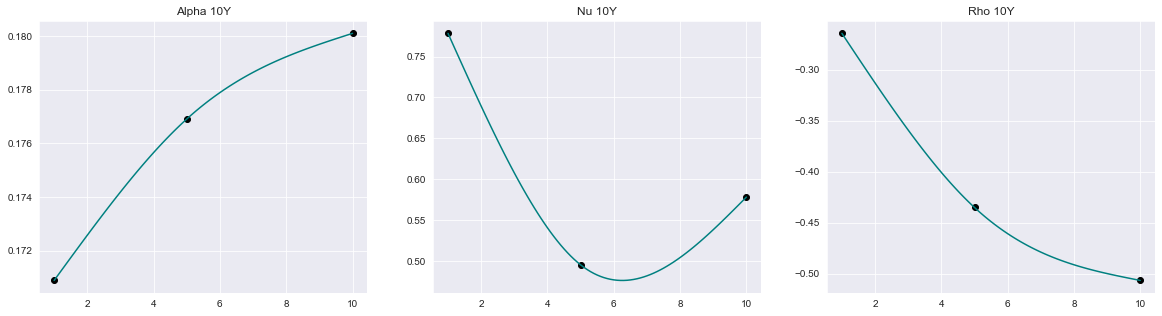

In [19]:
x_range = np.arange(1,10.1,0.1)
range_tst = [1,5,10]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

axes[0].plot(range_tst, alpha_df['10Y'], 'o', c='black')
axes[0].plot(x_range, [param_interpolation(x, 10, alpha_df) for x in x_range], c='teal')
axes[0].title.set_text('Alpha 10Y')
axes[0].grid()

axes[1].plot(range_tst, nu_df['10Y'], 'o', c='black')
axes[1].plot(x_range, [param_interpolation(x, 10, nu_df) for x in x_range],c='teal')
axes[1].title.set_text('Nu 10Y')
axes[1].grid()

axes[2].plot(range_tst, rho_df['10Y'], 'o', c='black')
axes[2].plot(x_range, [param_interpolation(x, 10, rho_df) for x in x_range],c='teal')
axes[2].title.set_text('Rho 10Y')
axes[2].grid()

plt.savefig('10Y.jpg')

## 2Y

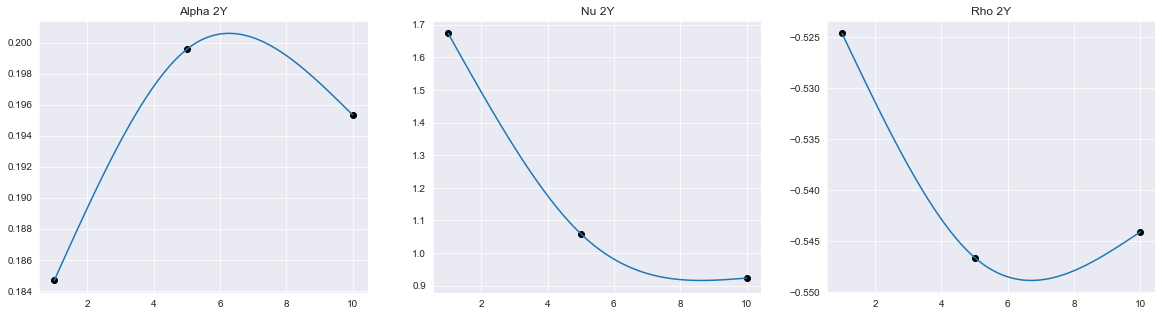

In [20]:
x_range = np.arange(1,10.1,0.1)
range_tst = [1,5,10]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

axes[0].plot(range_tst, alpha_df['2Y'], 'o', c='black')
axes[0].plot(x_range, [param_interpolation(x, 2, alpha_df) for x in x_range])
axes[0].title.set_text('Alpha 2Y')
axes[0].grid()

axes[1].plot(range_tst, nu_df['2Y'], 'o', c='black')
axes[1].plot(x_range, [param_interpolation(x, 2, nu_df) for x in x_range])
axes[1].title.set_text('Nu 2Y')
axes[1].grid()

axes[2].plot(range_tst, rho_df['2Y'], 'o', c='black')
axes[2].plot(x_range, [param_interpolation(x, 2, rho_df) for x in x_range])
axes[2].title.set_text('Rho 2Y')
axes[2].grid()

plt.savefig('2Y.jpg')

# Qn1: Using the SABR model to caliberate CMS products

In [21]:
# Calculating the PV of a leg receiving CMS10y semi annually over the next 5 years

cms_period = 5
tenor = 10
delta = 0.5

pv_5y = cms_pv(tenor, cms_period, delta)
print('The PV of a leg receiving CMS10y semi-annually over the next 5 years is:', pv_5y)

The PV of a leg receiving CMS10y semi-annually over the next 5 years is: 0.20913824140482562


In [22]:
# Calculating the PV of a leg receiving CMS2y quarterly over the next 5 years

cms_period = 10
tenor = 2
delta = 0.25

pv_10y = cms_pv(tenor, cms_period, delta)
print('The PV of a leg receiving CMS2y quarterly over the next 5 years is:', pv_10y)

The PV of a leg receiving CMS2y quarterly over the next 5 years is: 0.3852026988853911



# Qn2: Comparing the CMS Rate with the Forward Swap Rates from Part I

In [23]:
Expiry = ['1Y','5Y','10Y']
Tenor = ['1Y','2Y','3Y','5Y','10Y']

In [24]:
cmsr_df2 = []
fsr_df2 = []

expiries = [1, 5, 10]
tenors = [1, 2, 3, 5, 10]
delta = 0.5

for ex in expiries:
    for te in tenors:
        cms_r = cms(ex, te, delta)
        fs_r = Forward_Swap_Rate(ex, te, delta)
        cmsr_df2.append(cms_r)
        fsr_df2.append(fs_r)

In [25]:
cmsr_df2 = pd.DataFrame({'new_val':cmsr_df2})
cms_df = pd.DataFrame(data=cmsr_df2.values.reshape(3,5), index=['1Y', '5Y', '10Y'], columns=['1Y', '2Y', '3Y', '5Y', '10Y'])

fsr_df2 = pd.DataFrame({'new_val':fsr_df2})
fsr_df = pd.DataFrame(data=fsr_df2.values.reshape(3,5), index=['1Y', '5Y', '10Y'], columns=['1Y', '2Y', '3Y', '5Y', '10Y'])

index = ['1Y x 1Y', '1Y x 2Y', '1Y x 3Y', '1Y x 5Y', '1Y x 10Y',
         '5Y x 1Y', '5Y x 2Y', '5Y x 3Y', '5Y x 5Y', '5Y x 10Y',
         '10Y x 1Y', '10Y x 2Y', '10Y x 3Y', '10Y x 5Y', '10Y x 10Y']


cms_list = cmsr_df2.values.tolist()
swap_list = swap_rates.values.tolist()

swap_list_f=[]
decompose_lists(swap_list, swap_list_f)

cms_list_f=[]
decompose_lists(cms_list, cms_list_f)

In [26]:
rates_df = pd.DataFrame({"CMS":cms_list_f, "FSR":swap_list_f}, index=index)
rates_df['difference'] = rates_df['CMS'] - rates_df['FSR']

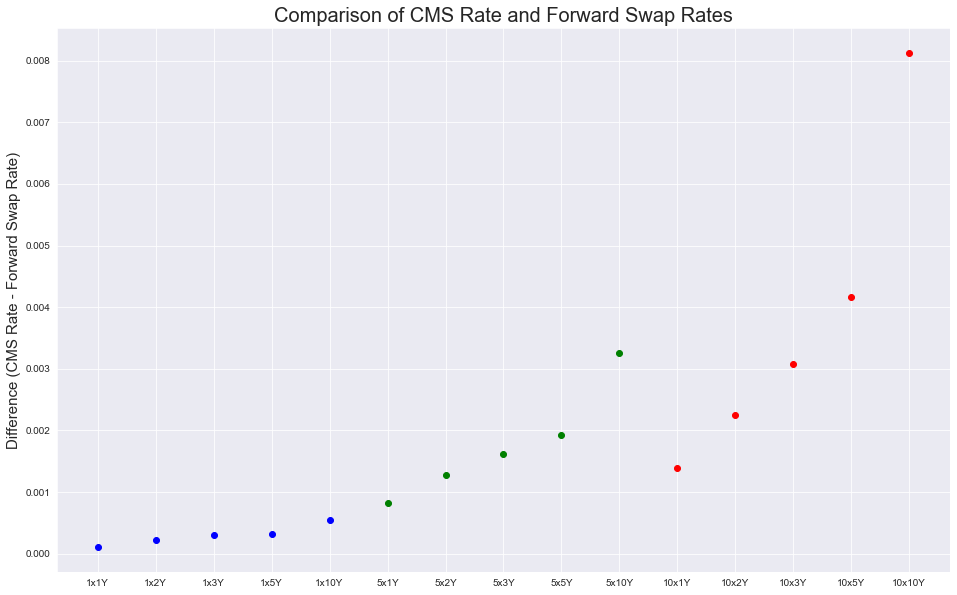

In [27]:
plt.figure(figsize=(16, 10))

plt.scatter(['1x1Y', '1x2Y', '1x3Y', '1x5Y', '1x10Y'], rates_df['difference'][:5], c = 'b')
plt.scatter(['5x1Y', '5x2Y', '5x3Y', '5x5Y', '5x10Y'], rates_df['difference'][5:10], c = 'g')
plt.scatter(['10x1Y', '10x2Y', '10x3Y', '10x5Y', '10x10Y'], rates_df['difference'][10:], c = 'r')

plt.grid()

plt.title('Comparison of CMS Rate and Forward Swap Rates', fontsize=20)
plt.ylabel('Difference (CMS Rate - Forward Swap Rate)', fontsize=15);

plt.savefig('compareA.jpg')

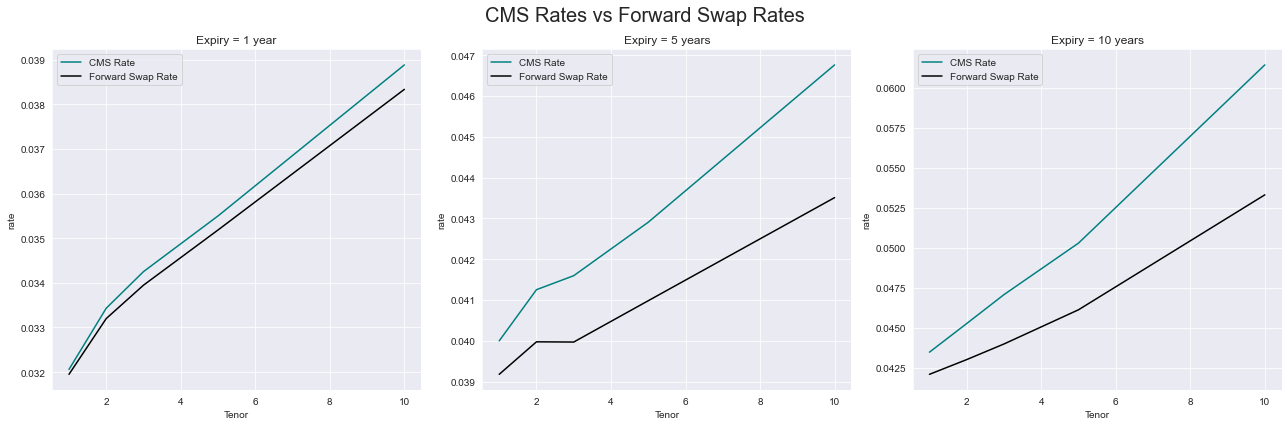

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
title_list = ['Expiry = 1 year', 'Expiry = 5 years', 'Expiry = 10 years']


for i in range(3):
    axes[i].plot(tenors,rates_df["CMS"][i*5:(i+1)*5],label="CMS Rate", c='teal')
    axes[i].plot(tenors,rates_df["FSR"][i*5:(i+1)*5],label="Forward Swap Rate", c='black')
    axes[i].title.set_text(title_list[i])
    axes[i].grid()
    axes[i].set_ylabel("rate")
    axes[i].set_xlabel("Tenor")
    axes[i].legend()

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle("CMS Rates vs Forward Swap Rates", fontsize=20)
plt.savefig('compareB.jpg')

plt.show()